This page will guide you on the different options the **NEST** package provides for dating stars.

You can download these docs as a jupyter notebook here {download}`tutorial.ipynb <_static/tutorial.ipynb>`

Start by importing the package:

In [22]:
import NEST

# List of available models
Each model is a neural network trained on a different evolutionary stellar grid.

In [23]:
NEST.available_models()

BaSTIModel (http://basti-iac.oa-abruzzo.inaf.it/)
PARSECModel (https://stev.oapd.inaf.it/PARSEC/)
MISTModel (https://waps.cfa.harvard.edu/MIST/)
GenevaModel (https://www.unige.ch/sciences/astro/evolution/en/database/syclist/)
DartmouthModel (https://rcweb.dartmouth.edu/stellar/)
YaPSIModel (http://www.astro.yale.edu/yapsi/)
BaSTI_HSTModel (http://basti-iac.oa-abruzzo.inaf.it/)


# Loading a model
By default, the age models use sklearn to run the neural networks. If you do not have it installed, or do not want to use it, you can pass the argument `use_sklearn=False` to switch to a numpy version.

```{note}
Be aware though, in this mode it becomes significantly slower once you run the models on more than ~100 stars
```

In [24]:
age_model = NEST.BaSTIModel()
#age_model = NNSA.BaSTIModel(use_sklearn=False)

```{tip}
The color and magnitudes are, for most models, in Gaia passbands. Magnitude is $M_G$ and color is $(G_{BP}-G_{RP})$. The only exception is the `BaSTI_HSTModel()`, which uses $F814W$ as magnitude and $(F606W - F814W)$ as color.

If in doubt, print `age_model` to get a description of it.
```

In [25]:
age_model

BaSTI Age Model, Gaia photometry: mag=MG, col=(GBP-GRP).

# Estimating the age of a star
To estimate the age of a star, use the `ages_prediction()` method, and pass it a metallicity met, magnitude mag and color col. Note that, with only these values provided, the return value is a np.array of shape (1,1). The reason will be clear if you check later uses. 

In [26]:
age_model.ages_prediction(met=0.0,mag=2.0,col=1.0)

array([[1.81505156]])

You can use the `check_domain()` method to verify that the star is within the bounds of the isochrones points used for training the neural networks. The function only checks for this in the HR Diagram, so you pass it a metallicity met, magnitude mag and color col.

In [27]:
age_model.check_domain(met=0.0,mag=2.0,col=1.0)

array([ True])

# Estimating the age of a star with GBP & GRP
If you are using Gaia magnitudes and colors, you can also pass the red GRP and blue GBP magnitudes separately as additional inputs. This generally results in better estimations.

In [28]:
age_model.ages_prediction(met=0.0,mag=2.0,col=1.0,GBP=2.0,GRP=1.0)

array([[1.34888727]])

# Estimating the age of multiple stars
If you pass lists of values of size N as inputs instead of single values, the return value of the `ages_prediction()` method will be a np.array of shape (N,1). Again, the reason for the 2D shape will be clear by checking later uses.
```{tip}
If you have tqdm installed, you can display the progress of the age predictions. By default, this display is on, but you can turn it off when you initiate the age_model by passing the argument `use_tqdm=False`.
```

In [29]:
age_model.ages_prediction(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5]
)

100%|██████████| 2/2 [00:00<00:00, 1544.86it/s]


array([[1.81505156],
       [5.83193499]])

In [30]:
age_model.ages_prediction(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5],
    GBP=[2.0,1.0],
    GRP=[1.0,0.5]
)

100%|██████████| 2/2 [00:00<00:00, 4464.40it/s]


array([[1.34888727],
       [2.20902813]])

You can also check if the stars are within the training domain all at once by passing lists of metallicity met, magnitude mag & color values col.

In [31]:
age_model.check_domain(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5]
)

100%|██████████| 2/2 [00:00<00:00, 9300.01it/s]


array([ True,  True])

That way, you can crossmatch both outputs to only keep stars whose age estimates we can reliably trust:

In [32]:
met = [0.0,-1.0,-2.0,-3.0]
mag = [2.0,3.0,3.0,5.0]
col = [1.0,0.5,0.5,0.5]
GBP = [2.0,1.0,1.0,1.0]
GRP = [1.0,0.5,0.5,0.5]
ages = age_model.ages_prediction(met=met,mag=mag,col=col,GBP=GBP,GRP=GRP)
print(ages)
inside_domain = age_model.check_domain(met=met,mag=mag,col=col)
print(inside_domain)
ages = ages[inside_domain]#Only keep ages of stars within the training domain of the NN
print(ages)

100%|██████████| 4/4 [00:00<00:00, 3174.50it/s]


[[1.34888727]
 [2.20902813]
 [3.38402904]
 [6.08718654]]


100%|██████████| 4/4 [00:00<00:00, 25850.87it/s]

[ True  True  True False]
[[1.34888727]
 [2.20902813]
 [3.38402904]]


# Estimating the age of a star with uncertainties
If you have uncertainty values for a star, you can pass them to the `ages_prediction()` method by adding values for emet, emag & ecol. The idea is that multiple age predictions will be made by offsetting the star's metallicity met, magnitude mag & color col by adding a random gaussian offset of width (emet,emag,ecol). The number of realisations made is controlled by the parameter n. The output of the method will then be a np.array of shape (1,n).

In [33]:
age_model.ages_prediction(met=0.0,mag=2.0,col=1.0,emet=0.1,emag=0.05,ecol=0.05,n=10)

100%|██████████| 1/1 [00:00<00:00, 2718.28it/s]


array([[1.77454952, 1.74958241, 1.74435121, 1.91421834, 1.5651886 ,
        5.18259712, 1.70983509, 1.91967307, 1.90506932, 2.10088398]])

Once the ages have been predicted for each star n times, you can call statistical methods `model.mean_ages()`, `model.median_ages()`, `model.mode_ages()` and `model.std_ages()`

In [34]:
print(age_model.mean_ages())
print(age_model.median_ages())
print(age_model.mode_ages())
print(age_model.std_ages())

[2.15659486]
[1.83980942]
[1.76503379]
[1.01827575]


# Estimating the age of multiple stars with uncertainties
Finally, you can combine multiple (N) stars age estimations and added uncertainties, with n Monte Carlo realisations. The output of the `ages_prediction()` method will then be a np.array of shape (N,n). A value of n=100 seems to be a good middle ground between speed and accurate predictions. If the number of stars is low, n>=1000 gives enough realisations to draw a PDF.

In [35]:
age_model.ages_prediction(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5],
    emet=[0.1,0.1],
    emag=[0.05,0.05],
    ecol=[0.05,0.05],
    n=10
)

100%|██████████| 2/2 [00:00<00:00, 1997.29it/s]


array([[1.76168224, 3.1555101 , 1.77115821, 1.68532355, 1.78303118,
        1.87311251, 1.72091295, 1.74423528, 1.82851454, 1.61385538],
       [5.76212721, 6.44460681, 6.02631269, 5.21768575, 6.59122978,
        7.33784522, 5.65996949, 5.04073524, 7.00020378, 5.81522349]])

In [36]:
print(age_model.mean_ages())
print(age_model.median_ages())
print(age_model.mode_ages())
print(age_model.std_ages())

[1.89373359 6.08959395]
[1.76642022 5.92076809]
[1.76868219 5.04216327]
[0.42608207 0.70685486]


# Working with big datasets
In the event you are working with big datasets, you might not want to store every sampled age for every star, as you might run out of memory to store all this information.
In this case, you can pass the argument ` store_samples=False ` to the ` age_prediction() ` method. Instead of returning a (N,n) np.array, the method will return a dict with keys ` mean `, ` median `, ` mode ` and ` std `, which each contain a (N) np.array with the given statistical property.

```{note}
Keep in mind this will cause a significant slowdown, as the statistical properties have to be computed for each star individually before discarding all its samples.
```

In [37]:
age_model.ages_prediction(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5],
    emet=[0.1,0.1],
    emag=[0.05,0.05],
    ecol=[0.05,0.05],
    n=100,
    store_samples=False
)

100%|██████████| 2/2 [00:00<00:00, 57.23it/s]


{'mean': array([2.2127412 , 5.90045337]),
 'median': array([1.816848  , 5.86648992]),
 'mode': array([1.725, 5.875]),
 'std': array([1.35423767, 0.71396834])}

# Coeval (cluster) population age
If you are dating a stellar population that is coeval, you might want to estimate the overall age of your population. To this end, after running the age prediction (with ` store_samples=True `), you can call the ` population_age() `. This works by multiplying individual age probability distribution functions (pdfs) together and returning the maximum value of this global pdf. By default, it uses 280 bins between 0 and 14 Gyr, but you can use the ` nbins `, ` min_age ` and ` max_age ` arguments to change this.

In [38]:
age_model.ages_prediction(
    met=[0.0,0.0],
    mag=[2.0,3.0],
    col=[1.0,0.5],
    emet=[0.05,0.05],
    emag=[0.05,0.05],
    ecol=[0.05,0.05],
    n=10_000
)

age_model.population_age()

100%|██████████| 100/100 [00:00<00:00, 4207.35it/s]


$\tau=1.73_{-0.25}^{+-0.05}\,\mathrm{Gyr}$

# Age model properties
- `age_model.samples` returns an (N,n,m) np.array of the latest samples used for the age predictions, if they were stored.
- `age_model.ages` returns an (N,n) np.array of the latest age predictions ran.
N : number of stars, n : number of samples, m : inputs dimension (3 if using metallicity,magnitude & color, 5 if using GBP & GRP in addition).

100%|██████████| 2/2 [00:00<00:00, 75.37it/s]


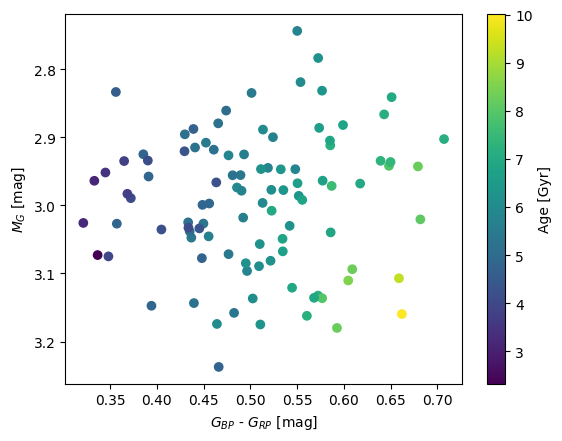

In [39]:
#Here is an example on how you can retrieve the samples
#of the age predictions to investigate individual predictions
age_model.ages_prediction(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5],
    emet=[0.1,0.1],
    emag=[0.1,0.1],
    ecol=[0.1,0.1],
    n=100
)

star_i = 1#Select the second star
magnitudes = age_model.samples[star_i,:,1]
colors = age_model.samples[star_i,:,2]
ages = age_model.ages[star_i]

import matplotlib.pyplot as plt
plt.scatter(colors,magnitudes,c=ages)
plt.colorbar(label='Age [Gyr]')
plt.xlabel(r'$G_{BP}$ - $G_{RP}$ [mag]')
plt.ylabel(r'$M_G$ [mag]')
plt.ylim(plt.ylim()[::-1]);

# Plotting an HR Diagram

```{warning}
You need the matplotlib package for this function.
```

To visualize your star sample in an HR Diagram, you can use the `HR_diagram()` method. It plots your stars, colored by their estimated age. It also plots isochrones from the evolutionary grid the age model Neural Network was trained on.

```{note}
By default, the curve data is not included in the NEST package, so the first time, you will be prompted to download them (27.9Mb).
```

The `isochrone_met` option lets you choose which set of isochrones will be plotted. You can choose between [M/H] = {-2,1,0}. This is a restricted range, so the displayed isochrones might not line up perfectly with your data points. Of course, the derived age was computed using the whole set of isochrones.

If you already ran `ages_prediction()`, the method will by default plot the stars colored by age. If you only want to plot isochrones, pass the `plot_stars=False` argument. The `age_type` option lets you choose the type of ages used to color the stars, between `'median'`, `'mean'` and `'mode'`. The `check_domain` option restricts the plotted stars to stars being in the domain of the training grid (`true` by default).

```{tip}
In an interactive matplotlib backend, you can hover over the isochrones to get their age. 
```

100%|██████████| 100/100 [00:00<00:00, 752.38it/s]


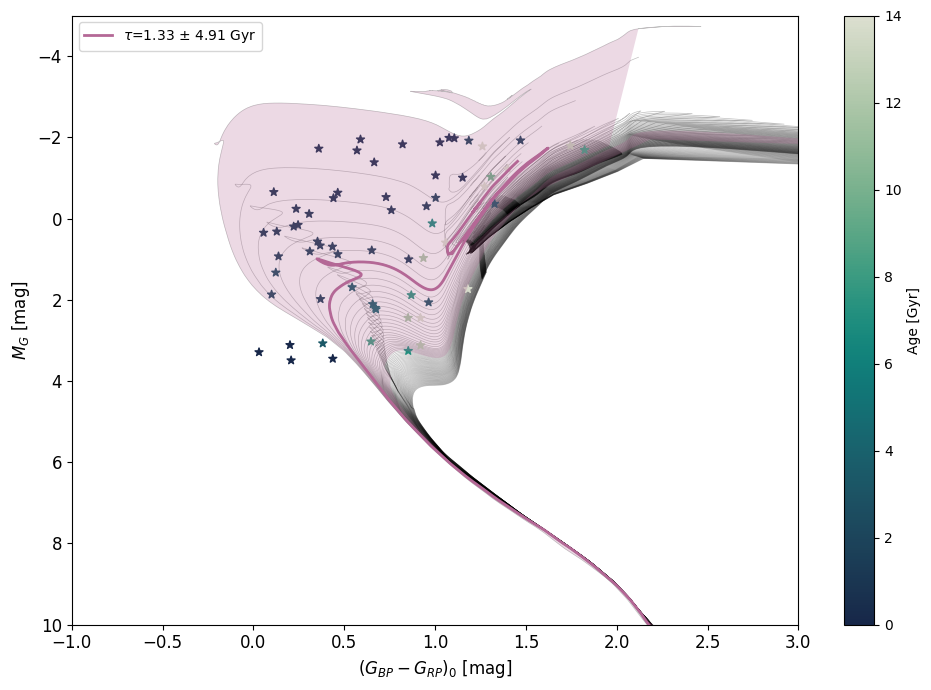

In [40]:
import numpy as np
import matplotlib.pyplot as plt

age_model = NEST.BaSTIModel()
met = np.random.uniform(-2, 0, size=100)
mag = np.random.uniform(-2, 4, size=100)
col = np.random.uniform( 0, 2, size=100)
age_model.ages_prediction(met=met,mag=mag,col=col)
age_model.HR_diagram();

Finally, if you are plotting a star population, the method will by default plot the isochrone with the same age as the overall age of the population (computed using `age_model.population_age()` if you stored samples, otherwise using the median of the type of individual ages you chose). You can disable this by setting `plot_isochrone` to `False`. If you want to plot a specific isochrone(s), you can set `isochrone_ages` to an age value in Gyr or a list of age values, as well as `isochrone_ages_std` for their associated uncertainties.

```{warning}
Currently, plotting exact individual isochrones is restricted to the BaSTI model, as it involves interpolation between a precomputed isochrone set, which is as of yet not fully implemented for other grids. For other models, the method will plot the closest isochrone in the available set of isochrones.
```

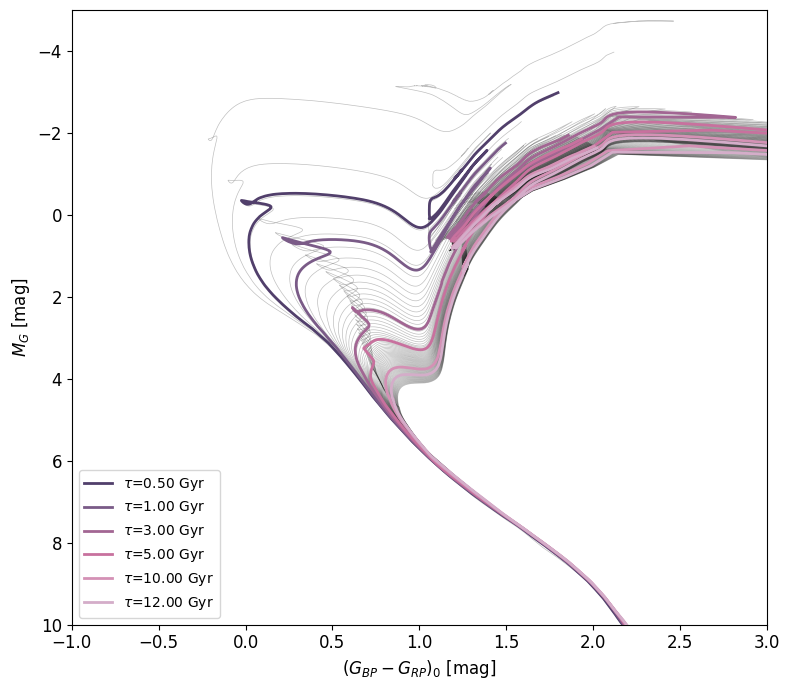

In [41]:
age_model = NEST.BaSTIModel()
fig,ax = age_model.HR_diagram(isochrone_ages=[0.5,1,3,5,10,12])

If you want to plot isochrones on one of your existing figures, you can pass the method your `fig` and `ax` objects, and nothing else. Otherwise, the `HR_diagram()` method returns a (`fig`,`ax`) tuple, so you can plot more objects on top by using the outputed figure and axis.

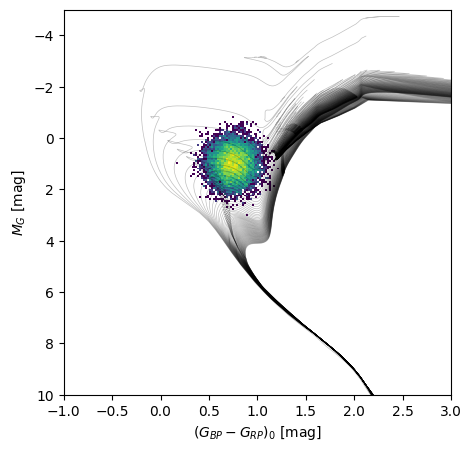

In [ ]:
from matplotlib.colors import LogNorm

fig,ax = plt.subplots(figsize=(5,5))

age_model = NEST.BaSTIModel()
age_model.HR_diagram(fig=fig,ax=ax)

mag = np.random.normal(1  , .5  , size=10_000)
col = np.random.normal(.75, .125, size=10_000)

ax.hist2d(col,mag,bins=200,range=((-1,3),(-5,10)),norm=LogNorm())

plt.xlim(-1,3)
plt.ylim(10,-5)

plt.xlabel(r'$(G_{BP} - G_{RP})_0$ [mag]')
plt.ylabel(r'$M_G$ [mag]');

There are a lot of parameters to customize the look of the plotted HR Diagram. Here is a list :
- `isochrone_met`=`0`. The metallicity (between -2,1 and 0) of the plotted set of isochrones.
- `plot_isochrone`=`True` Whether to plot the fitted isochrone of the stellar population.
- `plot_stars`=`True` Whether to plot individual stars.
- `plot_isochrone_uncertainty`=`True` Whether to plot uncertainties in the isochrones as shaded areas.
- `isochrone_ages`=`None,` An age value or list of age values of isochrones to be displayed.
- `isochrone_ages_std`=`None` The associated uncertainties.
- `age_type`=`'median'` Type of age to be used for coloring stars.
- `check_domain`=`True` Whether to remove stars outside of training domain.
- `fig`=`None` Existing figure to be used for plotting.
- `ax`=`None` Existing axis to be used for plotting.
- `star_cmap`=`cmaps['tempo_R']` Colormap to be used for stars.
- `isochrone_cmap`=`cmaps['acton']` Colormap to be used for isochrones.
- `loc_legend`=`'best'` Position of the legend.
- `axis_fontsize`=`12` Font size of the axes.
- `legend_fontsize`=`10` Font size of the legend.
- `colorbar_fontsize`=`10` Font size of the colorbar.
- `selected_isochrone_linewidth`=`2` Line width of the colored isochrones.
- `uncertainty_alpha`=`0.25` Opacity of the uncertainty shaded areas.
- `colorbar_lims`=`None` Limits of the colorbar for the stars scatter.